## Dataset Information

Investors are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months.

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
#from fbprophet import Prophet
from prophet import Prophet
# !pip install fbprophet
# install visual c++ - visual studio
# if you face errors - use conda install

Importing plotly failed. Interactive plots will not work.


## Loading the dataset

In [3]:
df = pd.read_csv('Traffic data.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
df

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
...,...,...,...
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580


## Preprocessing the dataset

In [5]:
# check null values
df.isnull().sum()

ID          0
Datetime    0
Count       0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [7]:
# convert object to datetime datatype
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


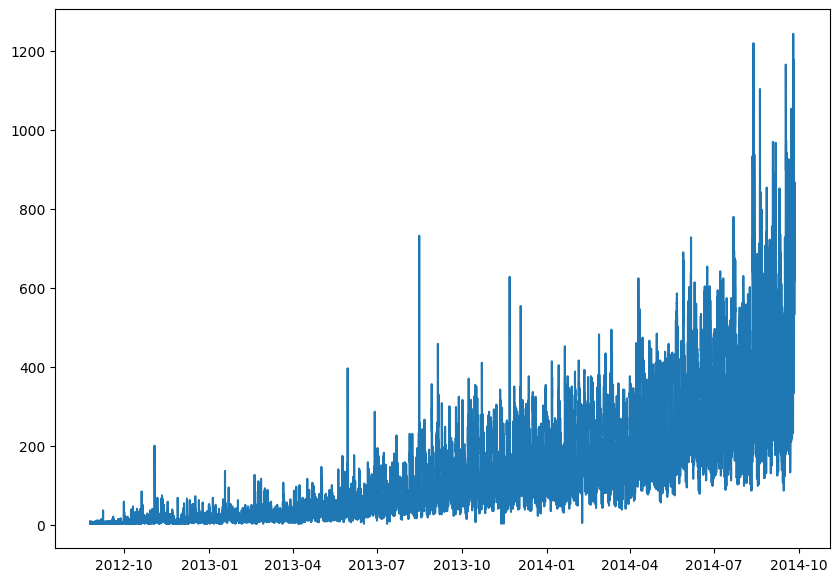

In [8]:
# EDA
plt.figure(figsize=(10,7))
plt.plot(df['Datetime'], df['Count'])
plt.show()

## Format data for the model

In [9]:
df.index = df['Datetime']
df['y'] = df['Count']

print(df)

                        ID            Datetime  Count    y
Datetime                                                  
2012-08-25 00:00:00      0 2012-08-25 00:00:00      8    8
2012-08-25 01:00:00      1 2012-08-25 01:00:00      2    2
2012-08-25 02:00:00      2 2012-08-25 02:00:00      6    6
2012-08-25 03:00:00      3 2012-08-25 03:00:00      2    2
2012-08-25 04:00:00      4 2012-08-25 04:00:00      2    2
...                    ...                 ...    ...  ...
2014-09-25 19:00:00  18283 2014-09-25 19:00:00    868  868
2014-09-25 20:00:00  18284 2014-09-25 20:00:00    732  732
2014-09-25 21:00:00  18285 2014-09-25 21:00:00    702  702
2014-09-25 22:00:00  18286 2014-09-25 22:00:00    580  580
2014-09-25 23:00:00  18287 2014-09-25 23:00:00    534  534

[18288 rows x 4 columns]


In [10]:
df.drop(columns=['ID', 'Datetime', 'Count'], axis=1, inplace=True)
df = df.resample('D').sum()
df.head()

,y
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [11]:
df['ds'] = df.index
df.head()

,y,ds
Datetime,,
2012-08-25,76,2012-08-25
2012-08-26,88,2012-08-26
2012-08-27,62,2012-08-27
2012-08-28,58,2012-08-28
2012-08-29,60,2012-08-29


## Input Split

In [12]:
size = 60
from sklearn.model_selection import train_test_split # to import my train_test_split function to split my dataset
train, test = train_test_split(df, test_size=size/len(df), shuffle=False) #shuffle is false to retain the dataset oerder

In [13]:
train.tail()

,y,ds
Datetime,,
2014-07-23,10130,2014-07-23
2014-07-24,8156,2014-07-24
2014-07-25,7192,2014-07-25
2014-07-26,6562,2014-07-26
2014-07-27,6094,2014-07-27


In [14]:
test.head()

,y,ds
Datetime,,
2014-07-28,8546,2014-07-28
2014-07-29,8218,2014-07-29
2014-07-30,8498,2014-07-30
2014-07-31,8740,2014-07-31
2014-08-01,9186,2014-08-01


In [15]:
test.tail()

,y,ds
Datetime,,
2014-09-21,9102,2014-09-21
2014-09-22,14116,2014-09-22
2014-09-23,13304,2014-09-23
2014-09-24,16856,2014-09-24
2014-09-25,14152,2014-09-25


## Model Training

In [16]:
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.9)
model.fit(train)

11:15:16 - cmdstanpy - INFO - Chain [1] start processing
11:15:16 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=60) #periods: Int number of periods to forecast forward, 
future

,ds
0,2012-08-25
1,2012-08-26
2,2012-08-27
3,2012-08-28
4,2012-08-29
...,...
757,2014-09-21
758,2014-09-22
759,2014-09-23
760,2014-09-24


In [18]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-480.337909,-1750.213040,155.019084,-480.337909,-480.337909,-339.583579,-339.583579,-339.583579,-846.171911,-846.171911,-846.171911,506.588331,506.588331,506.588331,0.0,0.0,0.0,-819.921488
1,2012-08-26,-473.321772,-1923.307933,-39.999109,-473.321772,-473.321772,-455.440680,-455.440680,-455.440680,-967.137423,-967.137423,-967.137423,511.696743,511.696743,511.696743,0.0,0.0,0.0,-928.762452
2,2012-08-27,-466.305636,-527.262139,1468.885155,-466.305636,-466.305636,946.509678,946.509678,946.509678,431.194541,431.194541,431.194541,515.315137,515.315137,515.315137,0.0,0.0,0.0,480.204042
3,2012-08-28,-459.289500,-469.373464,1410.951246,-459.289500,-459.289500,957.117210,957.117210,957.117210,439.558793,439.558793,439.558793,517.558416,517.558416,517.558416,0.0,0.0,0.0,497.827710
4,2012-08-29,-452.273363,-484.258181,1455.951119,-452.273363,-452.273363,918.302037,918.302037,918.302037,399.753865,399.753865,399.753865,518.548172,518.548172,518.548172,0.0,0.0,0.0,466.028674


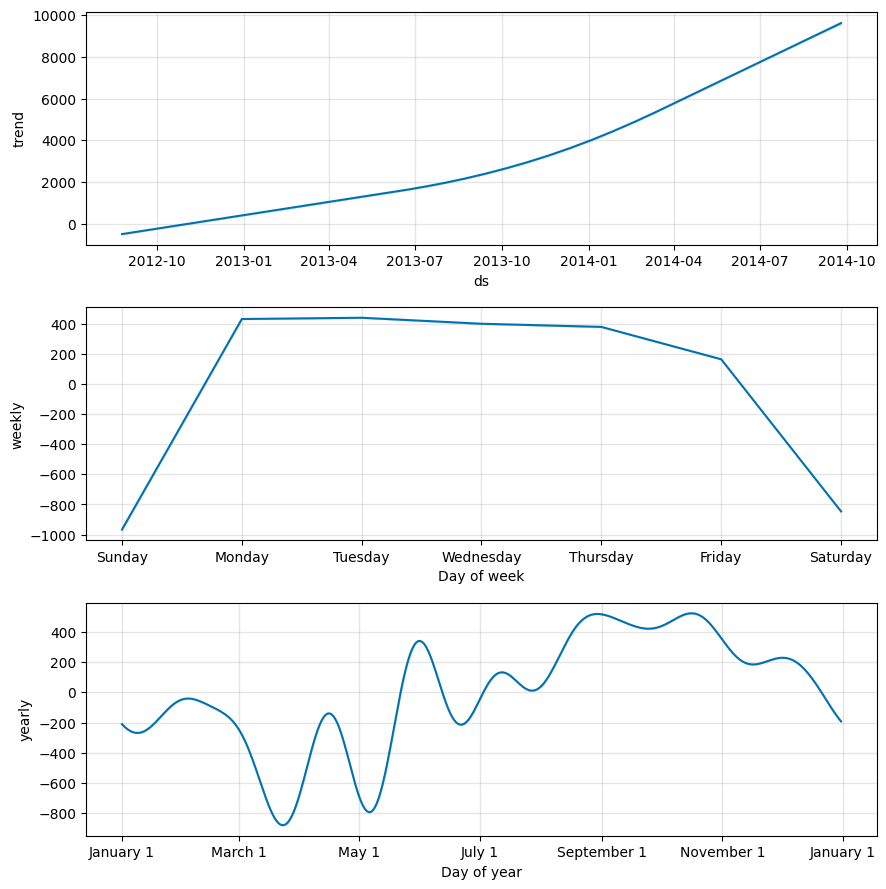

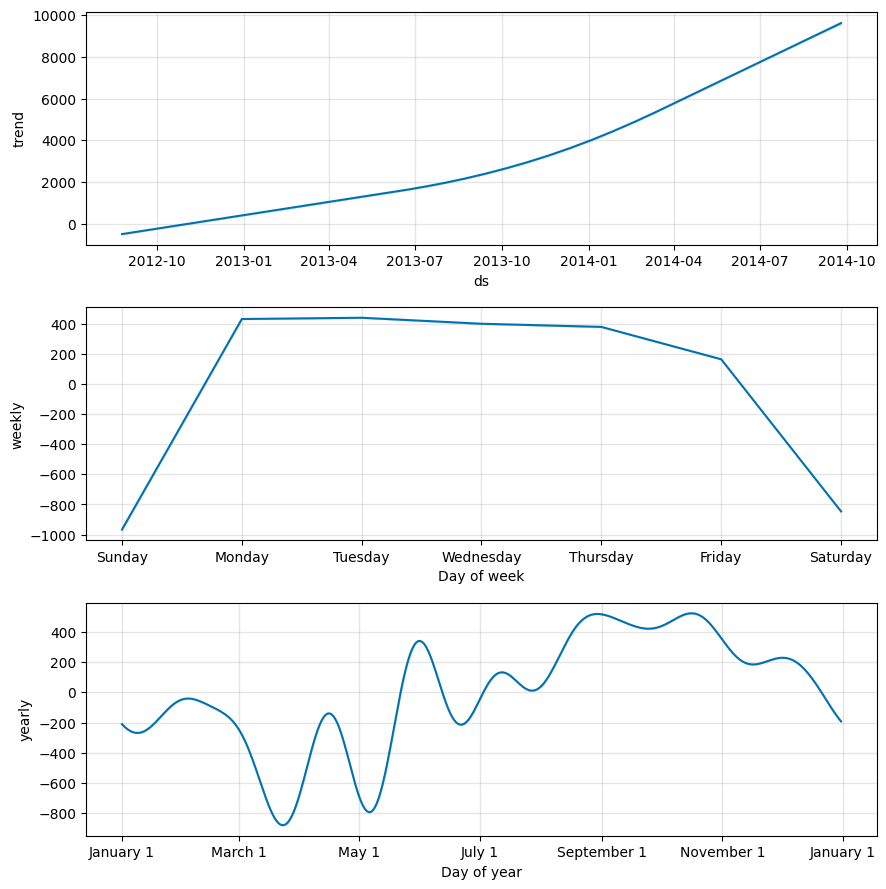

In [19]:
model.plot_components(forecast)

In [20]:
pred = forecast.iloc[-60:, :]
len(pred)

60

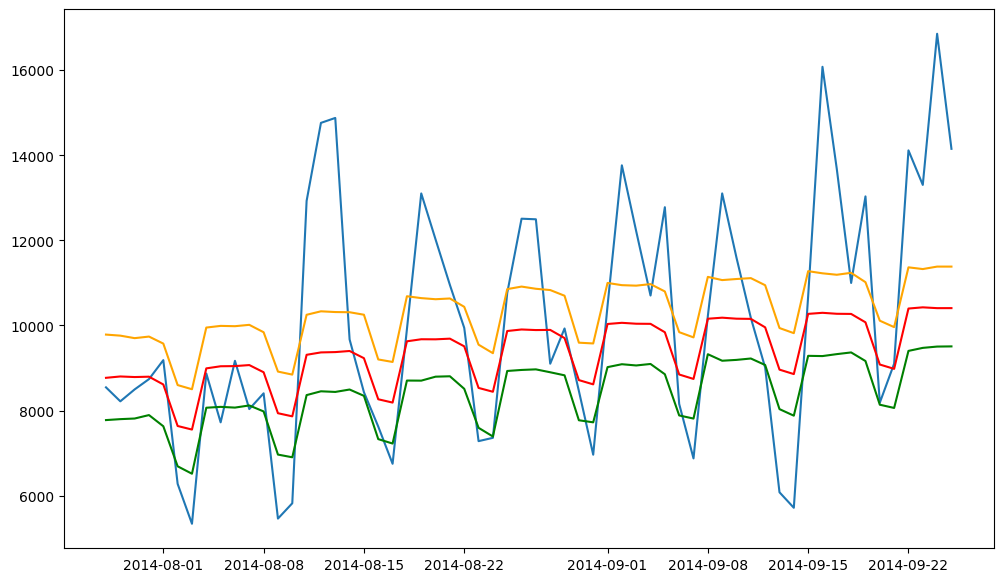

In [21]:
# test results
plt.figure(figsize=(12,7))
plt.plot(test['ds'], test['y'])
plt.plot(pred['ds'], pred['yhat'], color='red')
plt.plot(pred['ds'], pred['yhat_lower'], color='green')
plt.plot(pred['ds'], pred['yhat_upper'], color='orange')
plt.show()

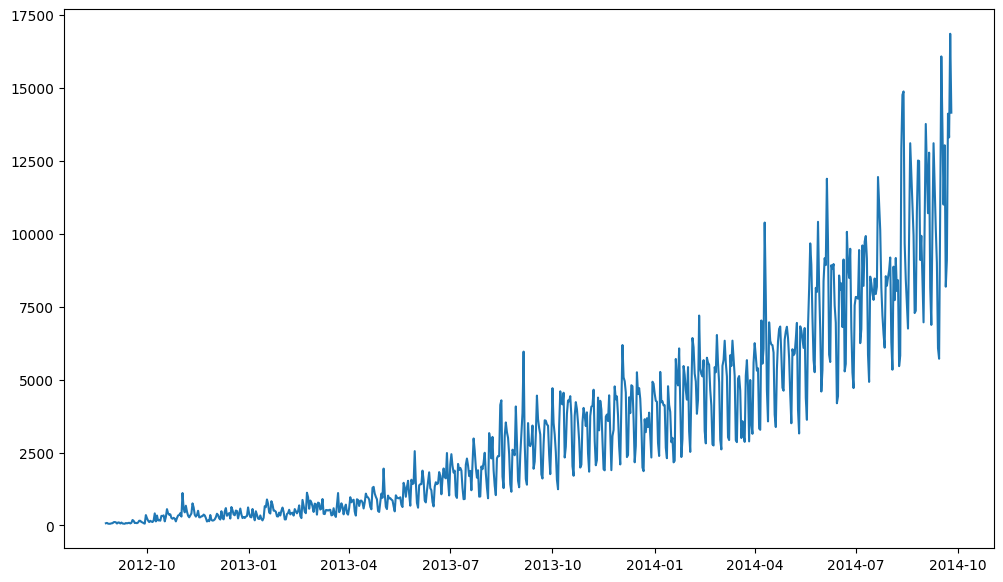

In [22]:
# input data
plt.figure(figsize=(12,7))
plt.plot(df['ds'], df['y'])
plt.show()

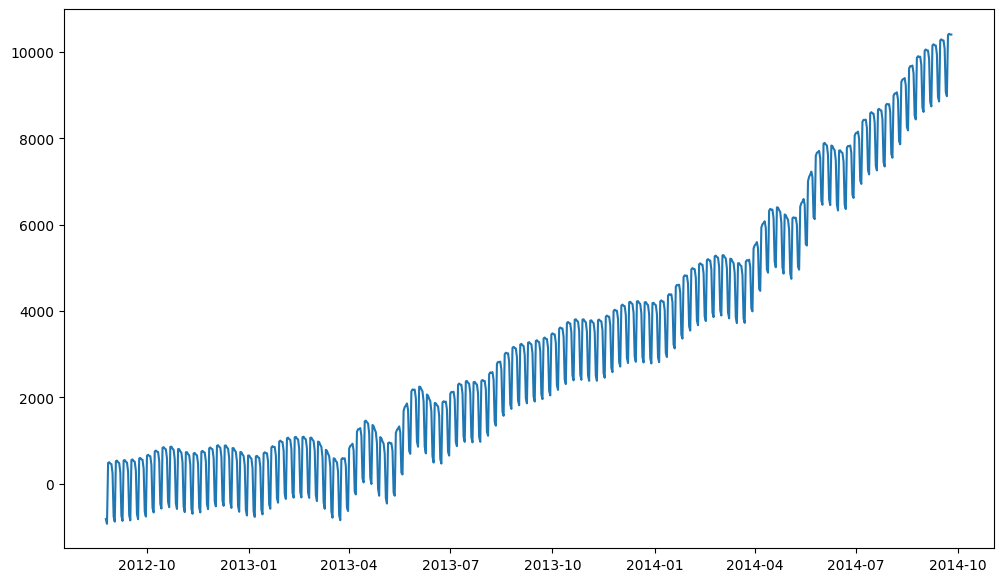

In [23]:
# forecast data
plt.figure(figsize=(12,7))
plt.plot(forecast['ds'], forecast['yhat'])
plt.show()

In [24]:
model = Prophet(yearly_seasonality=True, seasonality_prior_scale=0.9)
model.fit(df)
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)
forecast.head()

11:15:19 - cmdstanpy - INFO - Chain [1] start processing
11:15:19 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-678.420288,-2262.400682,67.543920,-678.420288,-678.420288,-426.080779,-426.080779,-426.080779,-995.205327,-995.205327,-995.205327,569.124548,569.124548,569.124548,0.0,0.0,0.0,-1104.501067
1,2012-08-26,-670.344293,-2420.487703,-39.740476,-670.344293,-670.344293,-584.291763,-584.291763,-584.291763,-1144.274888,-1144.274888,-1144.274888,559.983125,559.983125,559.983125,0.0,0.0,0.0,-1254.636056
2,2012-08-27,-662.268297,-801.511168,1542.411021,-662.268297,-662.268297,1005.578173,1005.578173,1005.578173,457.597131,457.597131,457.597131,547.981042,547.981042,547.981042,0.0,0.0,0.0,343.309876
3,2012-08-28,-654.192302,-728.501763,1652.842074,-654.192302,-654.192302,1142.316891,1142.316891,1142.316891,608.386711,608.386711,608.386711,533.930180,533.930180,533.930180,0.0,0.0,0.0,488.124589
4,2012-08-29,-646.116307,-863.060255,1602.676133,-646.116307,-646.116307,1075.584631,1075.584631,1075.584631,556.923289,556.923289,556.923289,518.661342,518.661342,518.661342,0.0,0.0,0.0,429.468325


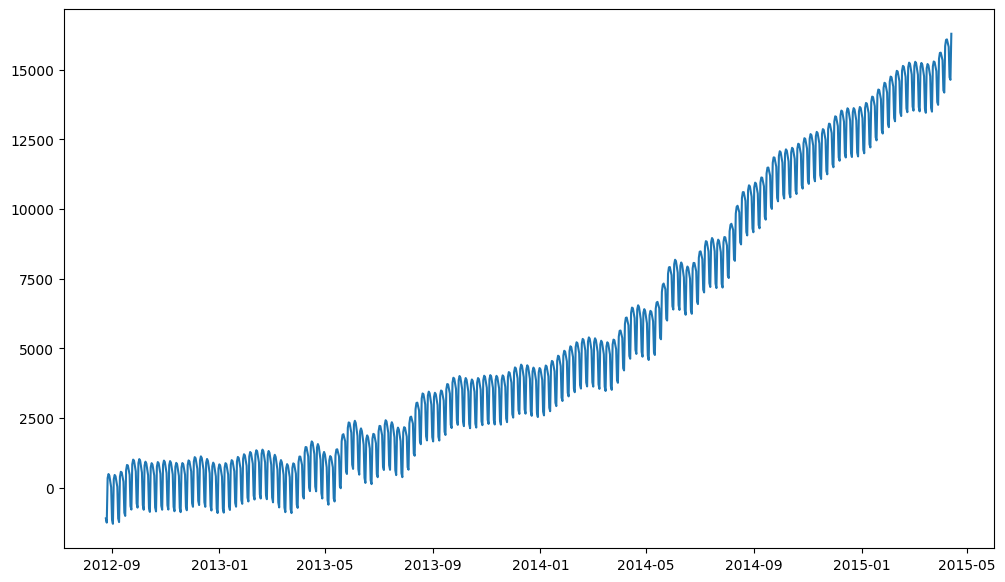

In [25]:
# forecast data
plt.figure(figsize=(12,7))
plt.plot(forecast['ds'], forecast['yhat'])
plt.show()

In [26]:
import pickle # Exporting the built model for external use

In [27]:
pickle.dump(model, open('time_series_forecast_model_P', mode = 'wb'))

In [28]:
import joblib

In [29]:
joblib.dump(model, 'time_series_forecast_model_J')

['time_series_forecast_model_J']